In [24]:
import matplotlib
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as manimation

from scipy.integrate import odeint 
import scipy

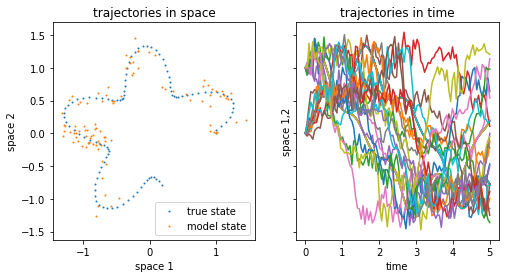

In [20]:
#Test guy-2012b method to compare simulation and observation data 

random_seed = 1 # used throughout the example 

np.random.seed(random_seed)

def f_true(x, dt):
    xc0 = x[:,0]+1j * x[:,1] 
    angle = np.angle(xc0)

    xc1 = (1+np.sin(5*angle)/3) * np.exp(1j * (angle+dt)) 
    return np.column_stack([np.real(xc1), np.imag(xc1)])

def f_model(x, dt, model_error):
    return f_true(x, dt) + np.random.randn(x.shape[0], x.shape[1]) * model_error

# Initial state of the true and simulated data
x0 = np.array([1,0]).reshape(1,-1)
x0 = x0 / np.linalg.norm(x0)

# Number of time steps for the given simulation
NT = 100
# Physical time that passes in the given number of time steps 
T=5
dt = T / NT
time = np.linspace(0,T,NT)

# this 'parameter' essentially defines how well the model approximates the true dynamics for this example.
# Values below 0.05 yield essentially no visible difference to the truth, while values above 0.1
# make the trajectories almost indistinguishable from noise, and only ensemble runs make it possible to evaluate
# the error and estimate the true state.

#model_error = 1e-0    # very noisy, entropy > 0
model_error = 1e-1 # very smooth, entropy < 0


# this is the error in the true model, and also in the observations. You do not need to change this.
true_error = 1e-4

m = 10 # ensemble runs
n = 1 # number of agents. Note that the models f_true and f_model only work for n=1.
d = 2 # dimension per "agent" (we only have one here) 
nd = n*d # total state dimension

xt = np.zeros((NT, (nd*m)))
# initialize the ensembles with randomly perturbed states
# in this example, this is not necessary because the model itself introduces errors
xt[0,:] = np.column_stack([x0+np.random.randn(1)/1000 for i in range(m*n)]) 
xm = xt.copy()
for k in range(1,NT): 
    for i in range(m):
        # using this as "true dynamics" means there is no noise in the true states (which is also ok)
        #xt[k,(i*n):((i+1)*n)]=(f_true(xt[k-1,(i*n):((i+1)*n)].reshape(1,-1),dt))
        # test what happens if the "true dynamics" are just a less noisy version of the model
        xt[k,(i*nd):((i+1)*nd)]=(f_model(xt[k-1,(i*nd):((i+1)*nd)].reshape(1,-1),dt, true_error))
        xm[k,(i*nd):((i+1)*nd)]=(f_model(xm[k-1,(i*nd):((i+1)*nd)].reshape(1,-1),dt, model_error))
fig,ax = plt.subplots(1,2,figsize=(8,4),sharey=True) 
ax[0].scatter(xt[:,0], xt[:,1],s=1,label='true state')
ax[0].scatter(xm[:,0], xm[:,1],s=1, label='model state')
ax[0].set_xlabel('space 1')
ax[0].set_ylabel('space 2')
ax[0].set_title('trajectories in space')
ax[0].legend()
ax[1].plot(time,xt);
ax[1].plot(time,xm);
ax[1].set_xlabel('time')
ax[1].set_ylabel('space 1,2')
ax[1].set_title('trajectories in time');

In [21]:
def normal_draw(cov):
    """ draw an n-dimensional point from a Gaussian distribution with given covariance. """
    return np.random.multivariate_normal(0*cov[:,0],cov,1)
def observation(x):
    # relatively simple observation function z=h(x), also no change in dimension 
    return (-x/2+np.cos(x)/3)
# compute ensemble Kalman smoothing
def algorithm1_enks(z_data, error_covariance_M, error_covariance_Q, observation, fhat_model):
    t = z_data.shape[0]
    ML = (error_covariance_M)
    QL = (error_covariance_Q)
    # initialize the initial guess for the model state with random numbers 
    # normally, one would probably have a better guess
    xk = np.random.randn(z_data.shape[0],z_data.shape[1])/10000
    
    for k in range(1,t):
        zk = np.zeros((z_data.shape[1],)) 
        for i in range(m):
            mkm1 = normal_draw(ML)
            xk[k,(i*nd):((i+1)*nd)] = fhat_model(xk[k-1,(i*nd):((i+1)*nd)].reshape(1,-1)) + mkm1
            qk = normal_draw(QL)
            zk[(i*nd):((i+1)*nd)] = observation(xk[k,(i*nd):((i+1)*nd)].reshape(1,-1)) + qk
            
        zkhat = 1/m*np.sum([zk[i::nd] for i in range(nd)],axis=1)
        zdiff = np.row_stack([(zk[(i*nd):((i+1)*nd)]-zkhat) for i in range(m)])
        Zk = np.cov(zdiff.T)
            
        for j in range(1,k+1):
            xjbar = np.array(1/m*np.sum([xk[j,i::nd] for i in range(nd)],axis=1))
            xdiff = np.row_stack([(xk[j,(i*nd):((i+1)*nd)]-xjbar) for i in range(m)])
            zdiff = np.row_stack([(zk[(i*nd):((i+1)*nd)]-zkhat) for i in range(m)])
                
            sigmaj = 1/(m-1) * (xdiff.T @ zdiff)
            matk = sigmaj @ np.linalg.pinv(Zk,rcond=1e-10) 
            for i in range(m):
                xk[j,(i*nd):((i+1)*nd)] = xk[j,(i*nd):((i+1)*nd)] + matk @ (z_data[k,(i*nd):((i+1)*nd)]-zk[(i*nd):((i+1)*nd)])
    return xk

def max_likelihood(xk, fhat_model):
    t = xk.shape[0]
    
    data = []
    for k in range(1, t-1):
        for i in range(m):
            fhat = fhat_model(xk[k,(i*nd):((i+1)*nd)].reshape(1,-1)) 
            xhat = xk[k+1,(i*nd):((i+1)*nd)] 
            data.append((xhat-fhat))
    data = np.row_stack(data)
    # note that we do not compute it "per agent", as in the paper guy-2019b,
    # but for all coordinates of the state (we only consider one "agent" in this code)
    return np.cov(data.T) 

np.random.seed(random_seed)
# this is the initial guess for the entropy matrix. can be pretty arbitrary
M = np.identity(n)
# this is the guess for the true error in the observations. should be small here.
Q = np.identity(n) * true_error**2
N_ITER = 5 # number of iterations of algorithm1_enks and max_likelihood 
Mhat = M
zk = observation(xt[1:,:])
xm_hat = 0
xm_hat_prev = 0
for k in range(N_ITER):
    xm_hat = algorithm1_enks(zk, Mhat, Q, observation, lambda x: f_model(x,dt,model_error));
    Mhat = max_likelihood(xm_hat, lambda x: f_model(x,dt,model_error)) 
    print('current det(M)', np.linalg.det(Mhat))
    print('error change ', np.linalg.norm(xm_hat - xm_hat_prev)) 
    xm_hat_prev = xm_hat

current det(M) 0.005884172807242312
error change  35.262749956946145
current det(M) 0.00013271131558958646
error change  10.985274606438644
current det(M) 0.00010023376454244568
error change  1.308615965274997
current det(M) 0.00010562260127770918
error change  0.8650717464672624
current det(M) 0.00010384953736814557
error change  0.850442315717133


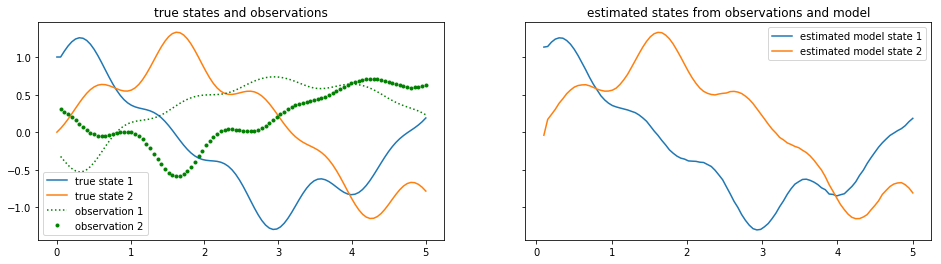

In [22]:
fig,ax = plt.subplots(1,2,figsize=(16,4),sharey=True)
ax[0].plot(time, xt[:,0],label='true state 1');
ax[0].plot(time, xt[:,1],label='true state 2');
ax[0].plot(time[1:], zk[:,0],'g:',label='observation 1');
ax[0].plot(time[1:], zk[:,1],'g.',label='observation 2');
ax[0].set_title('true states and observations')
ax[0].legend()

# this second plot shows the estimated MODEL (!) state, but since the model here is just the truth plus noise,
# the estimated model state should be the true state.
# We also skip the first state in xm_hat, since it was chosen at random. 
ax[1].plot(time[2:], xm_hat[1:,0],'-',label='estimated model state 1'); 
ax[1].plot(time[2:], xm_hat[1:,1],'-',label='estimated model state 2'); 
ax[1].set_title('estimated states from observations and model') 
ax[1].legend();

In [23]:
def entropy(M):
    return 1/2 * n * np.log((2*np.pi*np.exp(1))**d * np.linalg.det(M))
# print the estimated entropy against the known entropy.
# this is only possible in this computational experiment, because we normally do not know the 'true model' and the model error. 
print('entropy(M estimated) ', entropy(Mhat)) 
print('entropy(M true) ', entropy(np.identity(Mhat.shape[0])*model_error**2))

entropy(M estimated)  -1.7484066648209025
entropy(M true)  -1.7672931195787456
